<a href="https://colab.research.google.com/github/vitor-jarreta/Desenvolvimento-de-um-Sistema-Computacional-de-Identifica-o-de-Armas-de-Fogo-em-Ambientes-P-blicos/blob/main/DESENVOLVIMENTO_DE_UM_SISTEMA_COMPUTACIONAL_DE_IDENTIFICA%C3%87%C3%83O_DE_ARMAS_DE_FOGO_EM_AMBIENTES_P%C3%9ABLICOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Todos os direitos desse notebook são reservados á **Vitor Jarreta Ribeiro.**

Esse notebook é somente para estudo e obtenção do grau em Bacharel em Engenharia da Computação pela Universidade de Ribeirão Preto. O notebook é utilizado para o desenvolvimento do TCC (Trabalho de Conclusão de Curso).

#DESENVOLVIMENTO DE UM SISTEMA COMPUTACIONAL DE IDENTIFICAÇÃO DE ARMAS DE FOGO EM AMBIENTES PÚBLICOS

Este notebook tem como objetivo implementar um sistema de identificação de armas de fogo em ambientes públicos, utilizando técnicas avançadas de Visão Computacional e Redes Neurais Convolucionais (CNN). O foco será a aplicação do algoritmo YOLOv5 (You Only Look Once), uma das mais avançadas arquiteturas para detecção de objetos em tempo real, com a adaptação para a identificação de armas de fogo.

## Ferramentas e Tecnologias Utilizadas


*   Google Colab: Ambiente de desenvolvimento em nuvem com suporte a GPUs para treinamento de redes neurais.
*   YOLOv5: Arquitetura neural profunda para a detecção de objetos em tempo real.
* PyTorch: Framework utilizado para o desenvolvimento e treinamento das redes neurais.
* Dataset Personalizado: Um conjunto de dados contendo imagens rotuladas com a lozalização de armas de fogo.


## Objetivos


1. Pré-processamento das imagens: as imagens serão preparadas para a otimização do modelo
2. Treinamento do modelo: Será utilizado o YOLOv5n, uma versão mais leve do modelo YOLOv5, com classes personalizadas para detectar armas de fogo.
3. Avaliação do modelo: Os resultados serão avaliados com métricas como precisão e taxa de falso positivo/negativo.
4. Teste: O modelo será testado.

## Estrutura do Notebook
1. Configuração do ambiente: Instalação das pendências necessárias e bibliotecas a serem utilizadas.
2. Carregamento e preparação do dataset.
3. Configuração do YOLOv5 para classes personalizadas.
4. Treinamento do modelo.
5. Avaliação dos resultados.




##1. CONFIGURAÇÃO DO AMBIENTE

Esse primeiro tópico trará todas as configuraçõoes necessárias para que o notebook esteja pronto para treinar, testar e avaliar os resultados. Desta forma, as céculas abaixo trarão todas as infomrçãoes e bibliotecas necessárias para essa configuração.

Sempre limpar o diretório do Colab, para reiniciar os testes. Para o Colab por 150 segundos para ele limpar todo o diretório do colab.

In [1]:
!rm -rf /content/*

In [2]:
import time
time.sleep(30)

Instalar o Ultralytics, biblioteca que possui as versões do YOLOv5 e YOLOv8

In [12]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16982, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 16982 (delta 90), reused 108 (delta 53), pack-reused 16805 (from 1)
Receiving objects: 100% (16982/16982), 15.72 MiB | 17.65 MiB/s, done.
Resolving deltas: 100% (11623/11623), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.0/871.0 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


Configurar o Colab para que utilize a GPU e assim faça o treinamento e processamentos das redes e imagens de forma mais rápida.

Para isso siga as seguintes etapas:

1. Vá até o menu "Ambiente de execução"(Runtime) no Colab.
2. Seleciona "Alterar tipo de ambiente de execeução" (Change runtime type).
3. Em "Acelerador de Hardware" (Hardware Accelerator), selecione GPU (T4 GPU).
4. Clique em "Salvar" (Save).


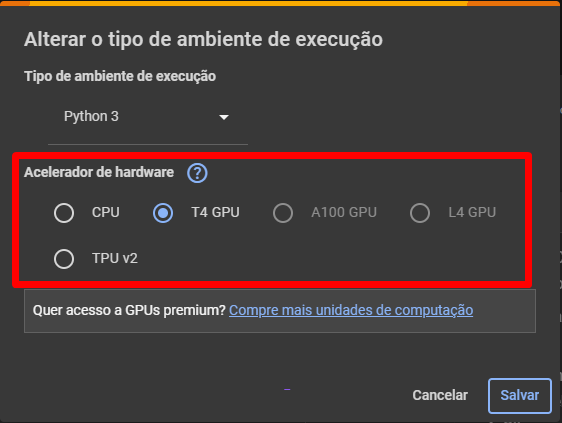

Verificar se GPU ta ativa via código.

In [4]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU está disponível!  Device:",device )
else:
    print("GPU não está disponível.")

GPU está disponível!  Device: cuda


Importando os restantes das bibliotecas que serão utilizadas

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import os
import random
from google.colab import files

Configurando as pastas e organização dos arquivos de treinamento, validação e teste.

In [6]:
# Definir a estrutura de pastas
dataset_path = '/content/dataset'
image_train_path = os.path.join(dataset_path, 'images/train')
image_val_path = os.path.join(dataset_path, 'images/val')
image_test_path = os.path.join(dataset_path, 'images/test')
label_train_path = os.path.join(dataset_path, 'labels/train')
label_val_path = os.path.join(dataset_path, 'labels/val')
label_test_path = os.path.join(dataset_path, 'labels/test')


# Criar as pastas
os.makedirs(image_train_path, exist_ok=True)
os.makedirs(image_val_path, exist_ok=True)
os.makedirs(image_test_path, exist_ok=True)
os.makedirs(label_train_path, exist_ok=True)
os.makedirs(label_val_path, exist_ok=True)
os.makedirs(label_test_path, exist_ok=True)

print("Estrutura de pastas criada com sucesso! De um Reload nos arquivos")

Estrutura de pastas criada com sucesso! De um Reload nos arquivos


##2. CARREGAMENTO E PREPARAÇÃO DO DATASET

Esse tópico contera todas as etapas necessárias para obter as imagens e configurar um dataset prórpio como manda o YOLO. Ou seja, onde as anotações das imagens, os bounding boxes, devem ser separados em um txt, essa sendo a pasta Labels.

Todo o DataSet será obtido por meio site Open Image Dataset

In [1]:
!pip install kaggle

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vitorjarreta","key":"f56c607895fea1350a554712ece2992b"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Garantir que o arquivo tenha as permissões corretas

### Dataset de Treinamento

A configuração do seguinte dataset será somente para o dataset de treinamento. Visto que para o Dataset de Teste é necessário um dataset sem infomações de labels dos objetos a serem identificados.

In [4]:
!kaggle datasets download -d snehilsanyal/weapon-detection-test --force

Dataset URL: https://www.kaggle.com/datasets/snehilsanyal/weapon-detection-test
License(s): CC0-1.0
100% 194M/194M [00:12<00:00, 20.4MB/s]
100% 194M/194M [00:12<00:00, 16.9MB/s]


In [10]:
!unzip /content/weapon-detection-test.zip -d /content/WeaponDetection

Archive:  /content/weapon-detection-test.zip
  inflating: /content/WeaponDetection/metadata.csv  
  inflating: /content/WeaponDetection/test/test/army.jpg  
  inflating: /content/WeaponDetection/test/test/giphy.gif  
  inflating: /content/WeaponDetection/test/test/mafia-mafia-game.gif  
  inflating: /content/WeaponDetection/test/test/terrorists.jpg  
  inflating: /content/WeaponDetection/test/test/terrorists2.jpg  
  inflating: /content/WeaponDetection/test/test/weapons.jpg  
  inflating: /content/WeaponDetection/test/test/weapons2.jpg  
  inflating: /content/WeaponDetection/test/test/weaponsgta5.gif  
  inflating: /content/WeaponDetection/weapon_detection/train/images/Automatic Rifle_10.jpeg  
  inflating: /content/WeaponDetection/weapon_detection/train/images/Automatic Rifle_100.jpeg  
  inflating: /content/WeaponDetection/weapon_detection/train/images/Automatic Rifle_11.jpeg  
  inflating: /content/WeaponDetection/weapon_detection/train/images/Automatic Rifle_12.jpeg  
  inflating: 

In [11]:
#os.remove('/content/yolov5/weapon-detection-test.zip')


# Conta o número de imagens na pasta
num_imagens_train = len([arquivo for arquivo in os.listdir('/content/WeaponDetection/weapon_detection/train/images') if arquivo.endswith(('.jpg', '.jpeg', '.png', '.gif'))])
num_imagens_val = len([arquivo for arquivo in os.listdir('/content/WeaponDetection/weapon_detection/val/images') if arquivo.endswith(('.jpg', '.jpeg', '.png', '.gif'))])
print(f"Total de imagens no dataset de treino depois de remover armas brancas: {num_imagens_train + num_imagens_val}")


list_remove =[
    '/content/WeaponDetection/weapon_detection/train/images',
    '/content/WeaponDetection/weapon_detection/train/labels',
    '/content/WeaponDetection/weapon_detection/val/images',
    '/content/WeaponDetection/weapon_detection/val/labels'
]

for path in list_remove:
  for filename in os.listdir(path):
    if 'Knife' in filename:
      file_path = os.path.join(path, filename)
      os.remove(file_path)
    elif 'Sword' in filename:
      file_path = os.path.join(path, filename)
      os.remove(file_path)
  print('Todas as imagens não armas de fogo foram removidas')


# Conta o número de imagens na pasta
num_imagens_train = len([arquivo for arquivo in os.listdir('/content/WeaponDetection/weapon_detection/train/images') if arquivo.endswith(('.jpg', '.jpeg', '.png', '.gif'))])
num_imagens_val = len([arquivo for arquivo in os.listdir('/content/WeaponDetection/weapon_detection/val/images') if arquivo.endswith(('.jpg', '.jpeg', '.png', '.gif'))])
print(f"Total de imagens no dataset de treino depois de remover armas brancas: {num_imagens_train + num_imagens_val}")

Total de imagens no dataset de treino depois de remover armas brancas: 714
Todas as imagens não armas de fogo foram removidas
Todas as imagens não armas de fogo foram removidas
Todas as imagens não armas de fogo foram removidas
Todas as imagens não armas de fogo foram removidas
Total de imagens no dataset de treino depois de remover armas brancas: 553


In [13]:
shutil.move('/content/WeaponDetection/weapon_detection/train/images', '/content/dataset/images/train')
shutil.move('/content/WeaponDetection/weapon_detection/train/labels', '/content/dataset/labels/train')
shutil.move('/content/WeaponDetection/weapon_detection/val/images', '/content/dataset/images/val')
shutil.move('/content/WeaponDetection/weapon_detection/val/labels', '/content/dataset/labels/val')

time.sleep(30)

In [14]:
shutil.rmtree('/content/WeaponDetection')
print('Arquivos movidos com sucesso e deletados do diretório anterior!!')

Arquivos movidos com sucesso e deletados do diretório anterior!!


In [15]:
list_dirc = [
    '/content/dataset/images/train/images',
    '/content/dataset/labels/train/labels',
    '/content/dataset/images/val/images',
    '/content/dataset/labels/val/labels'
]

for dirc in list_dirc:
    for filename in os.listdir(dirc):
        file_path = os.path.join(dirc, filename)
        if os.path.isfile(file_path):
            destination_dir = os.path.dirname(dirc)
            shutil.move(file_path, os.path.join(destination_dir, filename))
    os.removedirs(dirc)

print("Arquivos movidos para os diretórios pais com sucesso!")


Arquivos movidos para os diretórios pais com sucesso!


In [19]:
list_dirc = [
    '/content/dataset/images/train',
    '/content/dataset/labels/train',
    '/content/dataset/images/val',
    '/content/dataset/labels/val'
]


def rename_files():
  for dirc in list_dirc:
    name_file = sorted(os.listdir(dirc))
    for idx, filename in enumerate(name_file):
      file_extension = os.path.splitext(filename)[1]
      new_filename = f'gun_{idx+1}{file_extension}'

      old_file = os.path.join(dirc, filename)
      new_file = os.path.join(dirc, new_filename)

      os.rename(old_file, new_file)

  print('Arquivos renomeados com sucesso!')

rename_files()

##rename_files(list_dirc, 'gun')

Arquivos renomeados com sucesso!


In [20]:
label_dirs = [
    '/content/dataset/labels/train',
    '/content/dataset/labels/val'
]

# Função para verificar classes diferentes de 0
def check_labels_for_classes(label_dirs):
    for dir_path in label_dirs:
        for filename in os.listdir(dir_path):
            if filename.endswith('.txt'):  # Verifica se é um arquivo de label
                file_path = os.path.join(dir_path, filename)
                with open(file_path, 'r') as f:
                    for line in f:
                        class_id = int(line.split()[0])  # Pega o ID da classe
                        if class_id != 0:  # Verifica se a classe é diferente de 0
                            print(f"Classe diferente de 0 encontrada no arquivo: {file_path} - Classe: {class_id}")

# Verifica as classes nos arquivos de labels
check_labels_for_classes(label_dirs)


Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/train/gun_412.txt - Classe: 2
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/train/gun_395.txt - Classe: 2
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/train/gun_406.txt - Classe: 2
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/train/gun_430.txt - Classe: 2
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/train/gun_413.txt - Classe: 2
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/train/gun_397.txt - Classe: 2
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/train/gun_397.txt - Classe: 2
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/train/gun_439.txt - Classe: 2
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/train/gun_439.txt - Classe: 2
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/train/gun_394.txt - Classe: 2
Classe dif

In [21]:
# Caminhos para os diretórios de labels
label_dirs = [
    '/content/dataset/labels/train',
    '/content/dataset/labels/val'
]

def set_all_labels_to_zero(label_dirs):
    for dir_path in label_dirs:
        for filename in os.listdir(dir_path):
            if filename.endswith('.txt'):  # Verifica se é um arquivo de label
                file_path = os.path.join(dir_path, filename)
                # Lê o conteúdo atual do arquivo
                with open(file_path, 'r') as f:
                    lines = f.readlines()

                # Substitui todos os IDs de classe por 0
                with open(file_path, 'w') as f:
                    for line in lines:
                        parts = line.split()
                        parts[0] = '0'  # Define a classe como 0
                        f.write(' '.join(parts) + '\n')

# Executa a função para ajustar as classes
set_all_labels_to_zero(label_dirs)


In [22]:
check_labels_for_classes(label_dirs)

In [24]:
caminho_teste = '/content/dataset/images/train'

# Conta o número de imagens na pasta
num_imagens_teste = len([arquivo for arquivo in os.listdir(caminho_teste) if arquivo.endswith(('.jpg', '.jpeg', '.png'))])
print(f"Total de imagens no dataset de treino: {num_imagens_teste}")

Total de imagens no dataset de treino: 436


###Dataset de Teste

Os códigos abaixam serão utilizados para configurar o dataset que sera utilizado para o teste do treinamento da rede. As imagens contidas nesse dataset serão diferente do dataset de treino.

Para que isso fiquei confirmado essa diferenciação das imagens, será obtido pelo Kaggle, mas por um outro banco de dados públicos publicado na plataforma.

In [25]:
!unzip /content/DataSetTest.zip -d /content/DataSetTest

Archive:  /content/DataSetTest.zip
   creating: /content/DataSetTest/DataSetTest/
  inflating: /content/DataSetTest/DataSetTest/0a1cfb1bb8e135c2.jpg  
  inflating: /content/DataSetTest/DataSetTest/0a1cfb1bb8e135c2.txt  
  inflating: /content/DataSetTest/DataSetTest/0a3e254289429911.jpg  
  inflating: /content/DataSetTest/DataSetTest/0a3e254289429911.txt  
  inflating: /content/DataSetTest/DataSetTest/0c6f89a3d68c9530.jpg  
  inflating: /content/DataSetTest/DataSetTest/0c6f89a3d68c9530.txt  
  inflating: /content/DataSetTest/DataSetTest/1d1fbe960a9afc64.jpg  
  inflating: /content/DataSetTest/DataSetTest/1d1fbe960a9afc64.txt  
  inflating: /content/DataSetTest/DataSetTest/1d3cc55e51f756a6.jpg  
  inflating: /content/DataSetTest/DataSetTest/1d3cc55e51f756a6.txt  
  inflating: /content/DataSetTest/DataSetTest/1f6d2b6cd84c5789.jpg  
  inflating: /content/DataSetTest/DataSetTest/1f6d2b6cd84c5789.txt  
  inflating: /content/DataSetTest/DataSetTest/2aca4fe29c88ce64.jpg  
  inflating: /content

In [26]:
dir = '/content/DataSetTest/DataSetTest'

for filename in os.listdir(dir):
  if filename.endswith('.jpg'):
    shutil.move(os.path.join(dir, filename), '/content/dataset/images/test')
  elif filename.endswith('.txt'):
    shutil.move(os.path.join(dir, filename), '/content/dataset/labels/test')

print('Arquivos movidos com sucesso!!')

Arquivos movidos com sucesso!!


In [27]:
os.remove('/content/DataSetTest.zip')
shutil.rmtree('/content/DataSetTest/DataSetTest')
shutil.rmtree('/content/DataSetTest')

print('Arquivos e diretórios excluidos com sucesso!!')

Arquivos e diretórios excluidos com sucesso!!


In [29]:
list_dirc = [
    '/content/dataset/images/test',
    '/content/dataset/labels/test'
]


def rename_files():
  for dirc in list_dirc:
    name_file = sorted(os.listdir(dirc))
    for idx, filename in enumerate(name_file):
      file_extension = os.path.splitext(filename)[1]
      new_filename = f'teste_{idx+1}{file_extension}'

      old_file = os.path.join(dirc, filename)
      new_file = os.path.join(dirc, new_filename)

      os.rename(old_file, new_file)

  print('Arquivos renomeados com sucesso!')

rename_files()
##rename_files(list_dirc, 'test')

Arquivos renomeados com sucesso!


In [30]:
label_dirs = [
    '/content/dataset/images/test',
    '/content/dataset/labels/test'
]

check_labels_for_classes(label_dirs)
set_all_labels_to_zero(label_dirs)

Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/test/teste_11.txt - Classe: 16
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/test/teste_11.txt - Classe: 16
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/test/teste_11.txt - Classe: 15
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/test/teste_11.txt - Classe: 15
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/test/teste_11.txt - Classe: 15
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/test/teste_11.txt - Classe: 15
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/test/teste_18.txt - Classe: 15
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/test/teste_18.txt - Classe: 16
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/test/teste_32.txt - Classe: 15
Classe diferente de 0 encontrada no arquivo: /content/dataset/labels/test/teste_32.txt - Classe: 15


In [31]:
dir = '/content/dataset/images/test'

num_imagens_teste = len([arquivo for arquivo in os.listdir(dir) if arquivo.endswith(('.jpg', '.jpeg', '.png'))])
print(f"Total de imagens no dataset de teste: {num_imagens_teste}")

Total de imagens no dataset de teste: 45


In [32]:
check_labels_for_classes(label_dirs)

##3. Configuração do YOLOv5 para as Classes Personalizadas

In [33]:
yaml_content = """
train: /content/dataset/images/train
val: /content/dataset/images/val
test: /content/dataset/images/test

nc: 1
names: ['gun']
"""

with open('/content/dataset.yaml', 'w') as yaml_file:
    yaml_file.write(yaml_content)

    print('Arquivo YAML criado com sucesso!!')

Arquivo YAML criado com sucesso!!


##4. Treinamento do Modelo

In [34]:
!python train.py --img 640 --batch 16 --epochs 5 --data /content/dataset.yaml --cfg models/yolov5n.yaml --weights yolov5n.pt --name identified_gun_yolov5n_5epochs_V1

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
2024-10-10 14:06:14.953198: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 14:06:14.974238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 14:06:14.980568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5n.pt, cfg=models/yolov5n.yaml, da

In [ ]:
!python train.py --img 640 --batch 16 --epochs 10 --data /content/dataset.yaml --cfg models/yolov5n.yaml --weights yolov5n.pt --name identified_gun_yolov5n_10epochs_V2

2024-10-10 03:56:51.606511: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 03:56:51.627506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 03:56:51.633941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5n.pt, cfg=models/yolov5n.yaml, data=/content/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale

In [ ]:
!python train.py --img 640 --batch 16 --epochs 15 --data /content/dataset.yaml --cfg models/yolov5n.yaml --weights yolov5n.pt --name identified_gun_yolov5n_15epochs_V3

2024-10-10 03:58:19.489451: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 03:58:19.510345: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 03:58:19.516722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5n.pt, cfg=models/yolov5n.yaml, data=/content/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale

In [ ]:
!python train.py --img 640 --batch 16 --epochs 30 --data /content/dataset.yaml --cfg models/yolov5n.yaml --weights yolov5n.pt --name identified_gun_yolov5n_30epochs_V4

2024-10-10 04:08:05.488763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 04:08:05.509942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 04:08:05.516335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5n.pt, cfg=models/yolov5n.yaml, data=/content/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale

In [ ]:
!python train.py --img 640 --batch 16 --epochs 60 --data /content/dataset.yaml --cfg models/yolov5n.yaml --weights yolov5n.pt --name identified_gun_yolov5n_60epochs_V5

2024-10-10 04:15:24.271175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 04:15:24.293865: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 04:15:24.300335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5n.pt, cfg=models/yolov5n.yaml, data=/content/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=60, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale

In [ ]:
!python train.py --img 640 --batch 16 --epochs 75 --data /content/dataset.yaml --cfg models/yolov5n.yaml --weights yolov5n.pt --name identified_gun_yolov5n_75epochs_V6

2024-10-10 01:44:06.580368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-10 01:44:06.601151: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-10 01:44:06.607460: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5n.pt, cfg=models/yolov5n.yaml, data=/content/dataset.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=75, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale

In [ ]:
!python train.py --img 640 --batch 16 --epochs 100 --data /content/dataset.yaml --cfg models/yolov5n.yaml --weights yolov5n.pt --name identified_gun_yolov5n_100epochs_V7

A saída de streaming foi truncada nas últimas 5000 linhas.
  with torch.cuda.amp.autocast(amp):
      18/99      2.22G    0.03679    0.02368          0         83        640:  21% 6/28 [00:00<00:01, 11.17it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      18/99      2.22G    0.03782    0.02459          0         93        640:  21% 6/28 [00:00<00:01, 11.17it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
      18/99      2.22G    0.03759    0.02384          0         55        640:  29% 8/28 [00:00<00:01, 10.25it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(a

##5. Teste do Melhor Peso

In [ ]:
!python detect.py --weights /content/yolov5/runs/train/identified_gun_yolov5n_60epochs_V5/weights/best.pt --img 640 --conf 0.25 --source /content/dataset/images/test

detect: weights=['/content/yolov5/runs/train/identified_gun_yolov5n_60epochs_V5/weights/best.pt'], source=/content/dataset/images/test, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-371-g6629839d Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
YOLOv5n summary: 157 layers, 1760518 parameters, 0 gradients, 4.1 GFLOPs
image 1/45 /content/dataset/images/test/test_1.jpg: 448x640 (no detections), 37.2ms
image 2/45 /content/dataset/images/test/test_10.jpg: 448x640 1 gun, 6.1ms
image 3/45 /content/dataset/images/test/test_11.jpg: 480x640 (no detections), 38.1ms
i